In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-03-02 15:14:43.288227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 15:14:43.444162: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-02 15:14:44.177707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


2023-03-02 15:14:45.814287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 15:14:46.659160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:65:00.0, compute capability: 8.6


In [2]:
from local_utils import *

In [3]:
import pandas as pd
df_params = pd.read_pickle("../../bacterialcolony_dataset3/turing_df_circuit2_variant1_1000000parametersets.pkl")

In [4]:
df_params.head()

,DA,DB,bA,bB,bC,bD,bE,bF,VA,VB,...,nfe,nee,neb,nce,ss_n,ss_list,ss_class,system_class,maxeig,complex_dispersion
404,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,615.268976,73.210081,...,4.0,4.0,4.0,1.0,2.0,"[0.1997, 0.039, 10.9848, 104.771, 244.7529, 3....",stable spiral,turing I oscillatory,0.004898+0.036487j,True
2726,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,228.017071,94.502643,...,4.0,4.0,4.0,1.0,2.0,"[83.3645, 0.276, 12736.8586, 66.0485, 579.5646...",stable spiral,turing I oscillatory,0.000114+0.002647j,True
3508,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,23.538028,320.885489,...,4.0,4.0,4.0,1.0,3.0,"[6.9465, 0.1825, 57.5198, 3.3825, 131.0374, 1....",stable spiral,turing I oscillatory,0.001639+0.132134j,True
7516,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,16.205693,83.166774,...,4.0,4.0,4.0,1.0,1.0,"[1.7525, 0.2247, 908.552, 10.6864, 225.1614, 2...",stable spiral,turing I oscillatory,0.000652+0.003066j,True
7883,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,85.164519,738.495294,...,4.0,4.0,4.0,1.0,2.0,"[2.8165, 0.0136, 82.5102, 2.7508, 154.2711, 3....",stable spiral,turing I oscillatory,0.001346+0.016362j,True


In [5]:
import pickle

with open('../../bacterialcolony_dataset3/2Dfinal_circuit2_variant1_bc1.7_ca_ID546780_L8_J160_T125_N2500.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


In [6]:
ID = 546780
L = 8
data = np.array(ds_1)[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T=1
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
dxdy = x_size*y_size/L**2
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]

x_slice = slice(65, 100, 1)
y_slice = slice(65, 100, 1)

#data = data[:, x_slice, y_slice, np.newaxis]
#x_size = data.shape[1]
#y_size = data.shape[2]
#T = 1#data.shape[3]



indices_sub = indices_all[:, x_slice, y_slice]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

In [7]:
df_params.loc[ID,:]

DA                                                                  1.0
DB                                                                0.001
bA                                                                 0.01
bB                                                                 0.01
bC                                                                 0.01
bD                                                                 0.01
bE                                                                 0.01
bF                                                                 0.01
VA                                                            46.733347
VB                                                           134.697819
VC                                                            53.677758
VD                                                            44.231763
VE                                                            943.26562
VF                                                           605

In [20]:
data.shape

(6, 160, 160, 1)

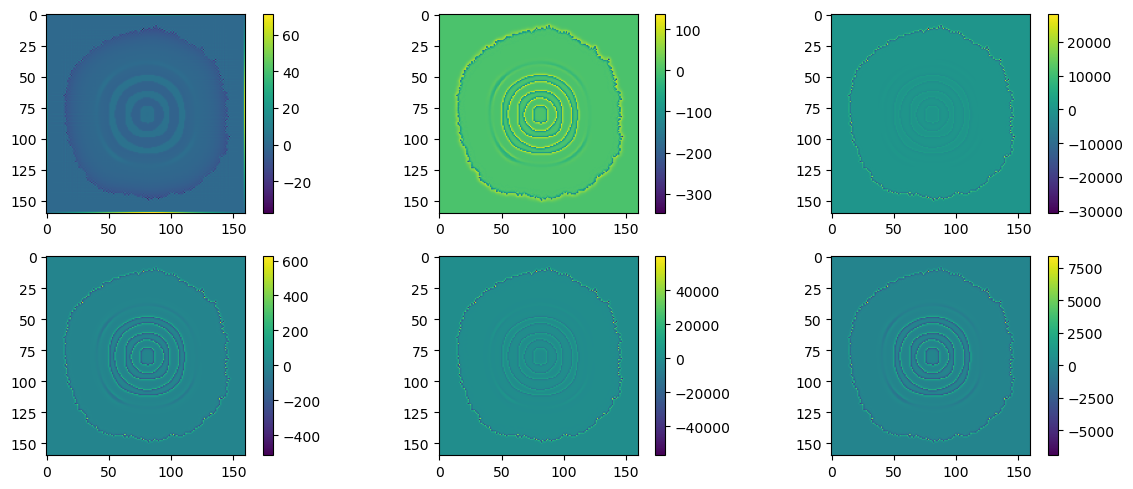

In [21]:
c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

# c_t = np.array([[(data_time[c, ..., t+1] -  data_time[c, ..., t])/(t_star_time[t+1] - t_star_time[t])
#                     for t in range(data.shape[3])]
#                     for c in range(data.shape[0])
#                    ])
# c_t = np.einsum("ctij -> cijt", c_t)

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow((c_xx[i,:, : , -1] + c_yy[i,:, : , -1]))
    plt.colorbar()
plt.tight_layout();plt.show()


In [11]:
c_xx.shape

(6, 160, 160, 1)

In [12]:
data.shape

(6, 160, 160, 1)

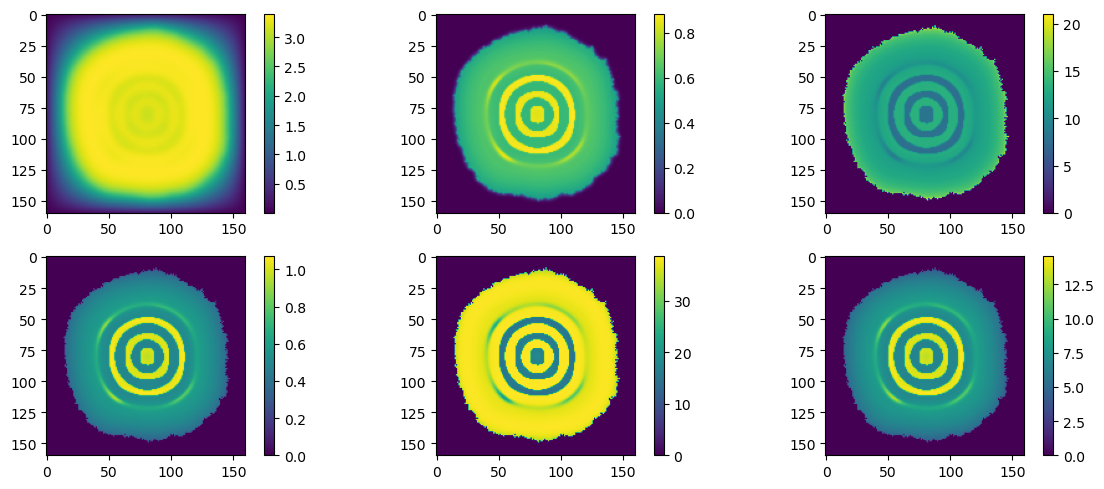

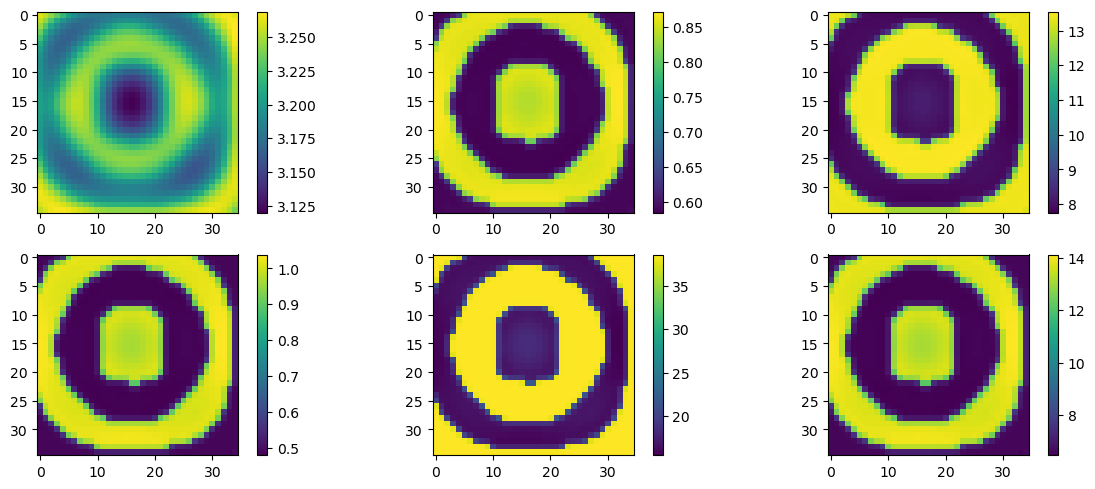

In [13]:
A = data[0, :, :, -1]
B = data[1, :, :, -1]
C = data[2, :, :, -1]
D = data[3, :, :, -1]
E = data[4, :, :, -1]
F = data[5, :, :, -1]

def activate(x, km, n=2):
    act = 1 / (1 + (km / (x + 1e-20)) ** (n))
    return act

def inhibit(x, km, n=2):
    inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
    return inh

params = df_params.loc[ID, :]
DA = params.DA    
DB = params.DB
bA = params.bA
bB = params.bB
bC = params.bC
bD = params.bD
bE = params.bE
bF = params.bF
VA = params.VA
VB = params.VB
VC = params.VC
VD = params.VD
VE = params.VE
VF = params.VF
Kab = params.Kab
Kbd = params.Kbd
Kce = params.Kce
Kda = params.Kda
Keb = params.Keb
Kee = params.Kee
Kfe = params.Kfe
muASV = params.muASV
muLVA = params.muLVA
nab = params.nab
nbd = params.nbd
nce = params.nce
nda = params.nda
nfe = params.nfe
neb = params.neb
nee = params.nee

A_rhs = DA * (c_xx[0, :, :, 0] + c_yy[0, :, :, 0])# - u_t
B_rhs = DB * (c_xx[1, :, :, 0] + c_yy[1, :, :, 0])# - v_t

f_A =  - bA - VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
f_B =  - bB - VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
f_C =  - bC - VC * inhibit(D, Kda, nda) + muLVA * C
f_D =  - bD - VD * activate(B, Kbd, nbd) + muLVA * D
f_E =  - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
f_F =  - bF - VF * activate(B, Kbd, nbd) + muLVA * F

c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [14]:
c_xx.shape

(6, 160, 160, 1)

In [15]:
c_restricted = data[:, x_slice, y_slice, :].copy()
c_xx_restricted = c_xx[:, x_slice, y_slice, :].copy()
c_yy_restricted = c_yy[:, x_slice, y_slice, :].copy() 
c_t_restricted = c_t[:, x_slice, y_slice, :].copy()

    
model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}


dataset = create_dataset_multi_nodes(data, t_star, N, 1, L, **model_params)
lb = dataset['lb']#[0:2]
#Since there are just one time step, we set the lb of T equal to zero
lb[-1] = 0.0
ub = dataset['ub']#[0:2]
obs_X = np.float32(dataset['obs_input'])#[:, 0:2])
obs_Y = np.float32(dataset['obs_output'])
#pde_X = np.float32(dataset['pde'])
ders_xx = np.float32(dataset['ders'][:, 0, :])
ders_yy = np.float32(dataset['ders'][:, 1, :])
ders_t = np.float32(dataset['ders'][:, 2, :])

In [16]:
A.shape

(160, 160)

In [17]:
obs_X.shape

(1225, 3)

In [18]:
def gen_series():    
    
    for i in range(obs_X.shape[0]):        
        yield obs_X[i,:], obs_Y[i,:], ders_xx[:, i], ders_yy[:, i], ders_t[:, i]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32, tf.float32, tf.float32, tf.float32), 
                                    output_shapes=((obs_X.shape[1],),(obs_Y.shape[1],),
                                                   (ders_xx.shape[0],),(ders_yy.shape[0],),
                                                   (ders_t.shape[0],)))

In [19]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        self.value = df_params.loc[ID,:][name]
        if value is None:
            self.value = df_params.loc[ID,:][name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[3, 128, 128, 6],
                learning_rate=1e-2,
                w1=1, w2=1, w3=1, w4=1, w5=100, w6=100,w7=1,w8=1,
                DA_val=tf_param("DA"), DB_val=tf_param("DB"),
                bA_val=tf_param("bA"),bB_val=tf_param("bB"),bC_val=tf_param("bC"),
                bD_val=tf_param("bD"),bE_val=tf_param("bE"),bF_val=tf_param("bF"),
                VA_val=tf_param("VA"),VB_val=tf_param("VB"),VC_val=tf_param("VC"),
                VD_val=tf_param("VD"),VE_val=tf_param("VE"),VF_val=tf_param("VF"),
                Kab_val=tf_param("Kab"),Kbd_val=tf_param("Kbd"),Kce_val=tf_param("Kce"),
                Kda_val=tf_param("Kda"),Keb_val=tf_param("Keb"),Kee_val=tf_param("Kee"),
                Kfe_val=tf_param("Kfe"),muASV_val=tf_param("muASV"),muLVA_val=tf_param("muLVA"),
                nab_val=tf_param("nab"),nbd_val=tf_param("nbd"),nce_val=tf_param("nce"),
                nda_val=tf_param("nda"),nfe_val=tf_param("nfe"),neb_val=tf_param("neb"),
                nee_val=tf_param("nee")):    
    #lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
    #ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    DA = create_tf_var(DA_val)    
    DB = create_tf_var(DB_val)
    bA = create_tf_var(bA_val)#
    bB = create_tf_var(bB_val)#
    bC = create_tf_var(bC_val)#
    bD = create_tf_var(bD_val)#
    bE = create_tf_var(bE_val)#
    bF = create_tf_var(bF_val)#
    VA = create_tf_var(VA_val)
    VB = create_tf_var(VB_val)
    VC = create_tf_var(VC_val)
    VD = create_tf_var(VD_val)
    VE = create_tf_var(VE_val)
    VF = create_tf_var(VF_val)
    Kab = create_tf_var(Kab_val)
    Kbd = create_tf_var(Kbd_val)
    Kce = create_tf_var(Kce_val)
    Kda = create_tf_var(Kda_val)
    Keb = create_tf_var(Keb_val)
    Kee = create_tf_var(Kee_val)
    Kfe = create_tf_var(Kfe_val)
    muASV = create_tf_var(muASV_val)
    muLVA = create_tf_var(muLVA_val)
    nab = create_tf_var(nab_val)
    nbd = create_tf_var(nbd_val)
    nce = create_tf_var(nce_val)
    nda = create_tf_var(nda_val)
    nfe = create_tf_var(nfe_val)
    neb = create_tf_var(neb_val)
    nee = create_tf_var(nee_val)
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")
    w5 = tf.Variable(w5,dtype=pinn.dtype,name="w5")
    w6 = tf.Variable(w6,dtype=pinn.dtype,name="w6")
    w7 = tf.Variable(w7,dtype=pinn.dtype,name="w7")
    w8 = tf.Variable(w8,dtype=pinn.dtype,name="w8")
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(DA_val, DA)
                    + as_tuple(DB_val, DB)
                    + as_tuple(bA_val, bA)
                    + as_tuple(bB_val, bB)
                    + as_tuple(bC_val, bC)
                    + as_tuple(bD_val, bD)
                    + as_tuple(bE_val, bE)
                    + as_tuple(bF_val, bF)
                    + as_tuple(VA_val, VA)
                    + as_tuple(VB_val, VB)
                    + as_tuple(VC_val, VC)
                    + as_tuple(VD_val, VD)
                    + as_tuple(VE_val, VE)
                    + as_tuple(VF_val, VF)
                    + as_tuple(Kab_val, Kab)
                    + as_tuple(Kbd_val, Kbd)
                    + as_tuple(Kce_val, Kce)
                    + as_tuple(Kda_val, Kda)
                    + as_tuple(Keb_val, Keb)
                    + as_tuple(Kee_val, Kee)
                    + as_tuple(Kfe_val, Kfe)
                    + as_tuple(muASV_val, muASV)
                    + as_tuple(muLVA_val, muLVA)
                    + as_tuple(nab_val, nab)
                    + as_tuple(nbd_val, nbd)
                    + as_tuple(nce_val, nce)
                    + as_tuple(nda_val, nda)
                    + as_tuple(nfe_val, nfe)
                    + as_tuple(neb_val, neb)
                    + as_tuple(nee_val, nee)
                   )

    @tf.function
    def train_step_inverse(elements):
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable


            with tf.GradientTape(persistent=True) as tape2:             
                tape2.watch(H)

                outputs = pinn.net(H)
                Ag = tf.squeeze(outputs[:, 0])
                Bg = tf.squeeze(outputs[:, 1])
#                 Cg = tf.squeeze(outputs[:, 2])
#                 Dg = tf.squeeze(outputs[:, 3])
#                 Eg = tf.squeeze(outputs[:, 4])
#                 Fg = tf.squeeze(outputs[:, 5])

                grad_A = tape2.gradient(Ag, H)
                A_x = grad_A[:, 0]
                A_y = grad_A[:, 1]

                grad_B = tape2.gradient(Bg, H)
                B_x = grad_B[:, 0]
                B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            A = tf.squeeze(elements[1][:, 0])
            B = tf.squeeze(elements[1][:, 1])
            C = tf.squeeze(elements[1][:, 2])
            D = tf.squeeze(elements[1][:, 3])
            E = tf.squeeze(elements[1][:, 4])
            F = tf.squeeze(elements[1][:, 5]) 

            act_A_xx = elements[2][:, 0]
            act_B_xx = elements[2][:, 1]
            act_A_yy = elements[3][:, 0]
            act_B_yy = elements[3][:, 1]

    #         act_A_t = elements[4][:, 0]
    #         act_B_t = elements[4][:, 1]
    #         act_C_t = elements[4][:, 2]
    #         act_D_t = elements[4][:, 3]
    #         act_E_t = elements[4][:, 4]
    #         act_F_t = elements[4][:, 5]            

            def activate(x, km, n=2):
                act = 1 / (1 + (km / (x + 1e-20)) ** (n))
                return act

            def inhibit(x, km, n=2):
                inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
                return inh

            A_rhs = DA * (A_xx + A_yy)# - u_t
            B_rhs = DB * (B_xx + B_yy)# - v_t

            f_A =  -bA -VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
            f_B =  -bB -VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
            f_C =  -bC -VC * inhibit(D, Kda, nda) + muLVA * C
            f_D =  -bD -VD * activate(B, Kbd, nbd) + muLVA * D
            f_E =  -bE -VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
            f_F =  -bF -VF * activate(B, Kbd, nbd) + muLVA * F
    #         f_C =  -act_C_t - bC - VC * inhibit(D, Kda, nda) + muLVA * C
    #         f_D =  -act_D_t - bD - VD * activate(B, Kbd, nbd) + muLVA * D
    #         f_E =  -act_E_t - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
    #         f_F =  -act_F_t - bF - VF * activate(B, Kbd, nbd) + muLVA * F

            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)
            l2_res_D = tf.reduce_sum(f_D**2)
            l2_res_E = tf.reduce_sum(f_E**2)
            l2_res_F = tf.reduce_sum(f_F**2)

            act_A_rhs = DA*(act_A_xx + act_A_yy) #- act_A_t
            act_B_rhs = DB*(act_B_xx + act_B_yy) #- act_B_t

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_res_A + w2*l2_res_B + w3*l2_res_C + w4*l2_res_D + 
                  w5*l2_res_E + w6*l2_res_F +  
                  w7*l2_res_A_rhs + w8*l2_res_B_rhs)
            #l2 = l2_res_A + l2_res_B  + l2_res_A_rhs + l2_res_B_rhs
            # l2 = l2_res_A_rhs + l2_res_B_rhs

        grads = tape.gradient(l2, trainables)
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, l2_res_C, l2_res_D, l2_res_E, l2_res_F,  
                l2_res_A_rhs, l2_res_B_rhs)
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C', 'l2_res_D', 'l2_res_E', 'l2_res_F',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5, w6, w7, w8)

In [34]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5, w6, w7, w8) = create_pinn(learning_rate=1e-2,
bA_val=tf_param("bA", 1, False),bB_val=tf_param("bB", 1, False),bC_val=tf_param("bC", 1, False),
bD_val=tf_param("bD", 1, False),bE_val=tf_param("bE", 1, False),bF_val=tf_param("bF", 1, False),
VA_val=tf_param("VA", 1, False),VB_val=tf_param("VB", 1, False),VC_val=tf_param("VC", 1, False),
VD_val=tf_param("VD", 1, False),VE_val=tf_param("VE", 1, False),VF_val=tf_param("VF", 1, False),
muASV_val=tf_param("muASV", 1, False), muLVA_val=tf_param("muLVA", 1, False),
w1=1, w2=1, w3=1, w4=1, w5=100, w6=100, w7=1, w8=1
)

(bA, bB, bC, bD, bE, bF, VA, VB, VC, VD, VE, VF, muASV, muLVA) = params_trainable1

DA: 1.0
DB: 0.001
bA: 1
bB: 1
bC: 1
bD: 1
bE: 1
bF: 1
VA: 1
VB: 1
VC: 1
VD: 1
VE: 1
VF: 1
Kab: 112.03598370729861
Kbd: 4.693803436565611
Kce: 0.9930030959145896
Kda: 0.2699281477606056
Keb: 45.269302324109745
Kee: 0.563496304565512
Kfe: 10.08286680374087
muASV: 1
muLVA: 1
nab: 1.0
nbd: 2.0
nce: 1.0
nda: 1.0
nfe: 4.0
neb: 4.0
nee: 4.0


In [35]:
epochs=100000+1
params_est = np.zeros((epochs, 14))

def epoch_callback1(epoch, loss_samples, index):
    params_est[epoch, : ] = (bA.numpy(), bB.numpy(), bC.numpy(), 
                             bD.numpy(), bE.numpy(), bF.numpy(),
                             VA.numpy(), VB.numpy(), VC.numpy(),
                             VD.numpy(), VE.numpy(), VF.numpy(),
                             muASV.numpy(), muLVA.numpy())
    
    
epochs2=100000+1
params_est2 = np.zeros((epochs2, 14))

def epoch_callback2(epoch, loss_samples, index):
    params_est2[epoch, : ] = (bA.numpy(), bB.numpy(), bC.numpy(), 
                             bD.numpy(), bE.numpy(), bF.numpy(),
                             VA.numpy(), VB.numpy(), VC.numpy(),
                             VD.numpy(), VE.numpy(), VF.numpy(),
                             muASV.numpy(), muLVA.numpy())    

In [36]:
obs_X.shape

(1225, 3)

In [37]:
losses1 = tu.train(epochs=epochs,
                  batch_size=1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)

optimizer1.lr.assign(1e-3)

losses2 = tu.train(epochs=epochs2,
                  batch_size=1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback2,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 1249128.165583372
l2_res_A: 4563.58154297, l2_res_B: 125.95787048, l2_res_C: 113184.94531250, l2_res_D: 161.24302673, l2_res_E: 1001418.18750000, l2_res_F: 117446.27343750, l2_res_A_rhs: 12223.97851562, l2_res_B_rhs: 3.99837756
bA:0: 1.010000228881836, bB:0: 0.9899997711181641, bC:0: 1.010000228881836, bD:0: 0.9899997711181641, bE:0: 1.010000228881836, bF:0: 1.010000228881836, VA:0: 1.010000228881836, VB:0: 0.9899997711181641, VC:0: 1.010000228881836, VD:0: 0.9899997711181641, VE:0: 1.010000228881836, VF:0: 1.010000228881836, muASV:0: 0.9899997711181641, muLVA:0: 0.9899997711181641
Time taken: 9.68s

Start of epoch 500
at epoch 500, total loss: 7046.544756442308
l2_res_A: 1994.14562988, l2_res_B: 5.09201336, l2_res_C: 128.21798706, l2_res_D: 0.22855285, l2_res_E: 589.63464355, l2_res_F: 180.47134399, l2_res_A_rhs: 4141.78857422, l2_res_B_rhs: 6.96601152
bA:0: 1.0249354839324951, bB:0: 0.5527434349060059, bC:0: 0.761660635471344, bD:0: 0.0416162


Start of epoch 7000
at epoch 7000, total loss: 946.0885760452079
l2_res_A: 393.64938354, l2_res_B: 20.46247864, l2_res_C: 0.00000023, l2_res_D: 0.00000000, l2_res_E: 0.00010598, l2_res_F: 0.00005850, l2_res_A_rhs: 510.36459351, l2_res_B_rhs: 21.61195564
bA:0: 0.0, bB:0: 1.36287522315979, bC:0: 0.0, bD:0: 2.0374225641717203e-05, bE:0: 0.000755839457269758, bF:0: 0.0, VA:0: 41.26089859008789, VB:0: 59.950687408447266, VC:0: 0.11906745284795761, VD:0: 0.09813027083873749, VE:0: 2.073390245437622, VF:0: 1.3506685495376587, muASV:0: 3.7619330883026123, muLVA:0: 0.0031669021118432283
Time taken: 21.87s

Start of epoch 7500
at epoch 7500, total loss: 851.8695940932121
l2_res_A: 373.87603760, l2_res_B: 18.75718689, l2_res_C: 0.00000010, l2_res_D: 0.00000000, l2_res_E: 0.00000979, l2_res_F: 0.00000489, l2_res_A_rhs: 438.69750977, l2_res_B_rhs: 20.53884506
bA:0: 0.0, bB:0: 1.3195544481277466, bC:0: 0.0, bD:0: 2.1538206055993214e-05, bE:0: 0.00019797671120613813, bF:0: 0.0, VA:0: 42.247249603271


Start of epoch 14000
at epoch 14000, total loss: 176.124915826294
l2_res_A: 84.46251678, l2_res_B: 1.98104203, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000138, l2_res_F: 0.00000010, l2_res_A_rhs: 87.43972778, l2_res_B_rhs: 2.24162769
bA:0: 0.0, bB:0: 0.3465059697628021, bC:0: 1.931200677063316e-05, bD:0: 2.2001191609888338e-05, bE:0: 0.0, bF:0: 3.093796840403229e-05, VA:0: 45.97264862060547, VB:0: 117.76377868652344, VC:0: 0.11809047311544418, VD:0: 0.0973348543047905, VE:0: 2.0755600929260254, VF:0: 1.3310291767120361, muASV:0: 4.176389694213867, muLVA:0: 0.003143609268590808
Time taken: 21.67s

Start of epoch 14500
at epoch 14500, total loss: 114.57917322302501
l2_res_A: 54.84615707, l2_res_B: 1.48575497, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000138, l2_res_F: 0.00000013, l2_res_A_rhs: 56.54320526, l2_res_B_rhs: 1.70405436
bA:0: 0.0, bB:0: 0.28204426169395447, bC:0: 1.917783447424881e-05, bD:0: 2.199874143116176e-05, bE:0: 0.0, bF:0: 3.8681122532


Start of epoch 21000
at epoch 21000, total loss: 110.73993120760005
l2_res_A: 54.54514313, l2_res_B: 0.76621664, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000138, l2_res_F: 0.00000010, l2_res_A_rhs: 54.64069366, l2_res_B_rhs: 0.78787625
bA:0: 0.003507177345454693, bB:0: 0.02918339893221855, bC:0: 1.9339368009241298e-05, bD:0: 2.2001911929692142e-05, bE:0: 0.0, bF:0: 2.8055248549208045e-05, VA:0: 46.40279006958008, VB:0: 132.9284210205078, VC:0: 0.1180824562907219, VD:0: 0.09732823073863983, VE:0: 2.075418710708618, VF:0: 1.331059217453003, muASV:0: 4.214646816253662, muLVA:0: 0.003143398556858301
Time taken: 21.97s

Start of epoch 21500
at epoch 21500, total loss: 68.94071954146531
l2_res_A: 32.71809006, l2_res_B: 0.67605489, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000138, l2_res_F: 0.00000011, l2_res_A_rhs: 34.84861755, l2_res_B_rhs: 0.69795549
bA:0: 0.0006134691648185253, bB:0: 0.025532178580760956, bC:0: 1.9236975276726298e-05, bD:0: 2.199274786107


Start of epoch 27500
at epoch 27500, total loss: 120.95957634852334
l2_res_A: 55.67472458, l2_res_B: 1.16501677, l2_res_C: 0.00077395, l2_res_D: 0.00000366, l2_res_E: 0.00451830, l2_res_F: 0.00068170, l2_res_A_rhs: 62.89848709, l2_res_B_rhs: 1.21537030
bA:0: 0.0001082150120055303, bB:0: 0.032109156250953674, bC:0: 0.0003274736227467656, bD:0: 0.00014963836292736232, bE:0: 0.00023837304615881294, bF:0: 0.000452644657343626, VA:0: 46.25379943847656, VB:0: 132.2832794189453, VC:0: 0.11793895810842514, VD:0: 0.09335300326347351, VE:0: 2.0765151977539062, VF:0: 1.323328971862793, muASV:0: 4.202192783355713, muLVA:0: 0.003018813906237483
Time taken: 22.32s

Start of epoch 28000
at epoch 28000, total loss: 91.5178290380482
l2_res_A: 44.59665680, l2_res_B: 1.09015560, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000138, l2_res_F: 0.00000009, l2_res_A_rhs: 44.67825317, l2_res_B_rhs: 1.15276194
bA:0: 0.0, bB:0: 0.03389738127589226, bC:0: 1.9358751160325482e-05, bD:0: 2.196168679802


Start of epoch 34000
at epoch 34000, total loss: 83.50349587276764
l2_res_A: 38.54073715, l2_res_B: 1.02482033, l2_res_C: 0.00038541, l2_res_D: 0.00000138, l2_res_E: 0.00223107, l2_res_F: 0.00037901, l2_res_A_rhs: 42.88357544, l2_res_B_rhs: 1.05136609
bA:0: 0.0002462132542859763, bB:0: 0.03272594138979912, bC:0: 0.00012674763274844736, bD:0: 0.0001241216086782515, bE:0: 9.751409379532561e-05, bF:0: 0.00028302756254561245, VA:0: 46.38835144042969, VB:0: 132.68177795410156, VC:0: 0.11808817088603973, VD:0: 0.09753959625959396, VE:0: 2.0762381553649902, VF:0: 1.3241387605667114, muASV:0: 4.214480876922607, muLVA:0: 0.0030649532563984394
Time taken: 22.65s

Start of epoch 34500
at epoch 34500, total loss: 81.04163403095383
l2_res_A: 38.71979523, l2_res_B: 0.98870486, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000140, l2_res_F: 0.00000010, l2_res_A_rhs: 40.29261398, l2_res_B_rhs: 1.04051840
bA:0: 0.0007818721351213753, bB:0: 0.03131373971700668, bC:0: 1.957310269062873e-05, 


Start of epoch 40500
at epoch 40500, total loss: 60.50648075384686
l2_res_A: 28.80717850, l2_res_B: 0.97207856, l2_res_C: 0.00002314, l2_res_D: 0.00000082, l2_res_E: 0.00013878, l2_res_F: 0.00003056, l2_res_A_rhs: 29.73835945, l2_res_B_rhs: 0.98867095
bA:0: 0.0, bB:0: 0.027794301509857178, bC:0: 1.669251469138544e-05, bD:0: 3.162340362905525e-05, bE:0: 2.2385413558367873e-06, bF:0: 0.00015768023149576038, VA:0: 46.52069854736328, VB:0: 133.26393127441406, VC:0: 0.11812213808298111, VD:0: 0.09746347367763519, VE:0: 2.0758063793182373, VF:0: 1.3258484601974487, muASV:0: 4.226232051849365, muLVA:0: 0.003141687484458089
Time taken: 22.31s

Start of epoch 41000
at epoch 41000, total loss: 36.43562927376479
l2_res_A: 16.23287201, l2_res_B: 0.91602689, l2_res_C: 0.22289222, l2_res_D: 0.01473408, l2_res_E: 1.34483123, l2_res_F: 0.20535180, l2_res_A_rhs: 16.56237793, l2_res_B_rhs: 0.93654311
bA:0: 0.0, bB:0: 0.02699127420783043, bC:0: 0.001687841024249792, bD:0: 0.0, bE:0: 0.001460439292713999


Start of epoch 47000
at epoch 47000, total loss: 62.78103134806865
l2_res_A: 31.38323212, l2_res_B: 0.90637583, l2_res_C: 0.00000019, l2_res_D: 0.00000002, l2_res_E: 0.00000190, l2_res_F: 0.00000192, l2_res_A_rhs: 29.56720543, l2_res_B_rhs: 0.92421395
bA:0: 0.0, bB:0: 0.02937021292746067, bC:0: 1.7314487195108086e-05, bD:0: 2.6634286768967286e-05, bE:0: 0.0, bF:0: 0.00012677385529968888, VA:0: 46.5797119140625, VB:0: 133.39942932128906, VC:0: 0.11809631437063217, VD:0: 0.09732361137866974, VE:0: 2.0755298137664795, VF:0: 1.3270403146743774, muASV:0: 4.231786251068115, muLVA:0: 0.003142278641462326
Time taken: 22.46s

Start of epoch 47500
at epoch 47500, total loss: 60.323132356628776
l2_res_A: 26.65906334, l2_res_B: 0.93970418, l2_res_C: 0.45271522, l2_res_D: 0.01991658, l2_res_E: 2.84638429, l2_res_F: 0.43385062, l2_res_A_rhs: 28.01278496, l2_res_B_rhs: 0.95871317
bA:0: 0.0016539935022592545, bB:0: 0.02663448639214039, bC:0: 0.0014637941494584084, bD:0: 0.0, bE:0: 0.00173214566893875


Start of epoch 53500
at epoch 53500, total loss: 32.88714315865189
l2_res_A: 15.78078842, l2_res_B: 1.03553307, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000138, l2_res_F: 0.00000049, l2_res_A_rhs: 15.01631069, l2_res_B_rhs: 1.05450904
bA:0: 0.0, bB:0: 0.027559032663702965, bC:0: 1.8625447410158813e-05, bD:0: 2.1918705897405744e-05, bE:0: 0.0, bF:0: 7.584554987261072e-05, VA:0: 46.599952697753906, VB:0: 133.4749298095703, VC:0: 0.1180681511759758, VD:0: 0.09731604903936386, VE:0: 2.0751631259918213, VF:0: 1.328890323638916, muASV:0: 4.233712196350098, muLVA:0: 0.0031429592054337263
Time taken: 22.43s

Start of epoch 54000
at epoch 54000, total loss: 21.655384220975407
l2_res_A: 9.86668110, l2_res_B: 1.02054238, l2_res_C: 0.00000041, l2_res_D: 0.00000002, l2_res_E: 0.00000400, l2_res_F: 0.00000169, l2_res_A_rhs: 9.72822762, l2_res_B_rhs: 1.03992701
bA:0: 0.0, bB:0: 0.026345517486333847, bC:0: 1.4863130672893021e-05, bD:0: 2.1392594135249965e-05, bE:0: 0.0, bF:0: 0.00013


Start of epoch 60000
at epoch 60000, total loss: 27.237956300804665
l2_res_A: 12.34344578, l2_res_B: 0.95309079, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000013, l2_res_A_rhs: 12.97173023, l2_res_B_rhs: 0.96968794
bA:0: 0.00034451548708602786, bB:0: 0.026564907282590866, bC:0: 1.9162784155923873e-05, bD:0: 2.1986050342093222e-05, bE:0: 0.0, bF:0: 3.881909651681781e-05, VA:0: 46.600040435791016, VB:0: 133.5066375732422, VC:0: 0.11805099993944168, VD:0: 0.0973021537065506, VE:0: 2.074864387512207, VF:0: 1.3302518129348755, muASV:0: 4.232566833496094, muLVA:0: 0.0031425461638718843
Time taken: 22.35s

Start of epoch 60500
at epoch 60500, total loss: 52.14602398088037
l2_res_A: 24.38492775, l2_res_B: 0.97709990, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000138, l2_res_F: 0.00000022, l2_res_A_rhs: 25.78340530, l2_res_B_rhs: 1.00058937
bA:0: 0.0006694658077321947, bB:0: 0.02314392291009426, bC:0: 1.8952177924802527e-05, bD:0: 2.19782759


Start of epoch 66500
at epoch 66500, total loss: 13.616830460101884
l2_res_A: 5.85082674, l2_res_B: 0.86906111, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000011, l2_res_A_rhs: 6.01949024, l2_res_B_rhs: 0.87745082
bA:0: 0.0, bB:0: 0.022251319140195847, bC:0: 1.9255463485023938e-05, bD:0: 2.1989390006638132e-05, bE:0: 0.0, bF:0: 3.278606163803488e-05, VA:0: 46.64876937866211, VB:0: 133.81488037109375, VC:0: 0.11804354935884476, VD:0: 0.0972960963845253, VE:0: 2.0747339725494385, VF:0: 1.3304214477539062, muASV:0: 4.23701286315918, muLVA:0: 0.00314235663972795
Time taken: 22.39s

Start of epoch 67000
at epoch 67000, total loss: 17.1570286442037
l2_res_A: 7.60653782, l2_res_B: 0.98364812, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000138, l2_res_F: 0.00000014, l2_res_A_rhs: 7.56321621, l2_res_B_rhs: 1.00362492
bA:0: 0.0, bB:0: 0.02844463661313057, bC:0: 1.913464438985102e-05, bD:0: 2.1984662453178316e-05, bE:0: 0.0, bF:0: 4.148874722886


Start of epoch 73000
at epoch 73000, total loss: 21.689786649983656
l2_res_A: 10.22981834, l2_res_B: 0.85854226, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 9.74302959, l2_res_B_rhs: 0.85839492
bA:0: 0.00026906479615718126, bB:0: 0.024047207087278366, bC:0: 1.9371591406525113e-05, bD:0: 2.2000045646564104e-05, bE:0: 0.0, bF:0: 2.561743531259708e-05, VA:0: 46.656219482421875, VB:0: 133.82937622070312, VC:0: 0.11803585290908813, VD:0: 0.09728990495204926, VE:0: 2.0745997428894043, VF:0: 1.3306360244750977, muASV:0: 4.237972259521484, muLVA:0: 0.0031421591993421316
Time taken: 22.34s

Start of epoch 73500
at epoch 73500, total loss: 22.00812314509257
l2_res_A: 9.76903629, l2_res_B: 0.85510576, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000010, l2_res_A_rhs: 10.51659775, l2_res_B_rhs: 0.86738181
bA:0: 0.0009947159560397267, bB:0: 0.02298014424741268, bC:0: 1.9296725440653972e-05, bD:0: 2.1988847


Start of epoch 79500
at epoch 79500, total loss: 17.860866314634173
l2_res_A: 7.72603130, l2_res_B: 1.01080990, l2_res_C: 0.00000009, l2_res_D: 0.00000000, l2_res_E: 0.00000158, l2_res_F: 0.00000012, l2_res_A_rhs: 8.09828377, l2_res_B_rhs: 1.02573955
bA:0: 0.001004261546768248, bB:0: 0.02246830426156521, bC:0: 1.8819944671122357e-05, bD:0: 2.0472100004553795e-05, bE:0: 0.0, bF:0: 2.3463078832719475e-05, VA:0: 46.662559509277344, VB:0: 133.77667236328125, VC:0: 0.11802902072668076, VD:0: 0.09728322178125381, VE:0: 2.074488639831543, VF:0: 1.3306306600570679, muASV:0: 4.237237930297852, muLVA:0: 0.0031425419729202986
Time taken: 22.56s

Start of epoch 80000
at epoch 80000, total loss: 33.665132024468434
l2_res_A: 15.33009815, l2_res_B: 1.03882968, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 16.23666000, l2_res_B_rhs: 1.05954266
bA:0: 0.0006935980054549873, bB:0: 0.02287290431559086, bC:0: 1.9361290469532833e-05, bD:0: 2.199194386


Start of epoch 86000
at epoch 86000, total loss: 15.0784830886696
l2_res_A: 6.52210331, l2_res_B: 1.03775203, l2_res_C: 0.00563178, l2_res_D: 0.00007468, l2_res_E: 0.03484397, l2_res_F: 0.00531282, l2_res_A_rhs: 6.41604900, l2_res_B_rhs: 1.05671549
bA:0: 0.0, bB:0: 0.02375631034374237, bC:0: 0.0, bD:0: 0.0, bE:0: 0.0, bF:0: 0.0, VA:0: 46.676761627197266, VB:0: 133.74288940429688, VC:0: 0.1176973208785057, VD:0: 0.09650993347167969, VE:0: 2.0741169452667236, VF:0: 1.330273151397705, muASV:0: 4.239755630493164, muLVA:0: 0.0034121929202228785
Time taken: 22.77s

Start of epoch 86500
at epoch 86500, total loss: 12.425760127980265
l2_res_A: 5.11612797, l2_res_B: 1.02512360, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 5.24049711, l2_res_B_rhs: 1.04400992
bA:0: 0.0, bB:0: 0.02169554866850376, bC:0: 1.9367847926332615e-05, bD:0: 2.1991720132064074e-05, bE:0: 0.0, bF:0: 2.646619759616442e-05, VA:0: 46.65937423706055, VB:0: 133.790237426


Start of epoch 92500
at epoch 92500, total loss: 18.14562854866108
l2_res_A: 8.00195122, l2_res_B: 1.05495036, l2_res_C: 0.00100717, l2_res_D: 0.00000991, l2_res_E: 0.00642006, l2_res_F: 0.00100035, l2_res_A_rhs: 8.00449562, l2_res_B_rhs: 1.07579386
bA:0: 0.0, bB:0: 0.024187931790947914, bC:0: 0.00011743207141989842, bD:0: 0.00013368747022468597, bE:0: 0.00010805580677697435, bF:0: 0.00028513948200270534, VA:0: 46.67521667480469, VB:0: 133.7383575439453, VC:0: 0.11803985387086868, VD:0: 0.0972994789481163, VE:0: 2.0752549171447754, VF:0: 1.3239030838012695, muASV:0: 4.239258289337158, muLVA:0: 0.003085498232394457
Time taken: 22.26s

Start of epoch 93000
at epoch 93000, total loss: 29.19706951020646
l2_res_A: 13.86194038, l2_res_B: 1.06842089, l2_res_C: 0.00002830, l2_res_D: 0.00000154, l2_res_E: 0.00017917, l2_res_F: 0.00002641, l2_res_A_rhs: 13.17989922, l2_res_B_rhs: 1.08657360
bA:0: 0.0, bB:0: 0.023262858390808105, bC:0: 3.2088228181237355e-06, bD:0: 0.0, bE:0: 0.0, bF:0: 7.814998


Start of epoch 99500
at epoch 99500, total loss: 17.30158329398546
l2_res_A: 7.47605705, l2_res_B: 1.04793656, l2_res_C: 0.00986517, l2_res_D: 0.00009942, l2_res_E: 0.06351671, l2_res_F: 0.00918593, l2_res_A_rhs: 7.63215542, l2_res_B_rhs: 1.06276703
bA:0: 0.0, bB:0: 0.022652611136436462, bC:0: 0.00012820545816794038, bD:0: 0.0, bE:0: 5.0258589908480644e-05, bF:0: 0.0002381275116931647, VA:0: 46.662227630615234, VB:0: 133.8235626220703, VC:0: 0.11753308027982712, VD:0: 0.09180368483066559, VE:0: 2.0752739906311035, VF:0: 1.321929693222046, muASV:0: 4.239290237426758, muLVA:0: 0.003203638130798936
Time taken: 22.62s

Start of epoch 100000
at epoch 100000, total loss: 16.346652364433876
l2_res_A: 6.91401672, l2_res_B: 1.04322147, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 7.32719469, l2_res_B_rhs: 1.06221795
bA:0: 0.0005196012789383531, bB:0: 0.021719209849834442, bC:0: 1.935594809765462e-05, bD:0: 2.1984133127261885e-05, bE:0: 0


Start of epoch 6000
at epoch 6000, total loss: 6.425323105194188
l2_res_A: 2.12814140, l2_res_B: 1.02301955, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 2.23807859, l2_res_B_rhs: 1.03608203
bA:0: 2.257983578601852e-05, bB:0: 0.019358471035957336, bC:0: 1.9349934518686496e-05, bD:0: 2.1975669369567186e-05, bE:0: 0.0, bF:0: 2.532984217396006e-05, VA:0: 46.70985794067383, VB:0: 134.01593017578125, VC:0: 0.11801228672266006, VD:0: 0.09727059304714203, VE:0: 2.0741848945617676, VF:0: 1.3303813934326172, muASV:0: 4.242094993591309, muLVA:0: 0.0031415377743542194
Time taken: 22.62s

Start of epoch 6500
at epoch 6500, total loss: 6.593679767537186
l2_res_A: 2.22367382, l2_res_B: 1.01815641, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000138, l2_res_F: 0.00000010, l2_res_A_rhs: 2.31988883, l2_res_B_rhs: 1.03195918
bA:0: 8.46400362206623e-05, bB:0: 0.01898106560111046, bC:0: 1.9358007193659432e-05, bD:0: 2.202332871092949e-


Start of epoch 12500
at epoch 12500, total loss: 5.820828969778718
l2_res_A: 1.86468184, l2_res_B: 0.97579491, l2_res_C: 0.00000096, l2_res_D: 0.00000001, l2_res_E: 0.00000606, l2_res_F: 0.00000060, l2_res_A_rhs: 1.98885238, l2_res_B_rhs: 0.99149221
bA:0: 0.0, bB:0: 0.017382357269525528, bC:0: 2.9518178052967414e-05, bD:0: 2.6864167011808604e-05, bE:0: 4.369797352410387e-06, bF:0: 4.240177440806292e-05, VA:0: 46.71333694458008, VB:0: 134.0873565673828, VC:0: 0.11802547425031662, VD:0: 0.09734399616718292, VE:0: 2.0742599964141846, VF:0: 1.3300358057022095, muASV:0: 4.242400169372559, muLVA:0: 0.0031351426150649786
Time taken: 22.66s

Start of epoch 13000
at epoch 13000, total loss: 5.335966353555705
l2_res_A: 1.59304106, l2_res_B: 0.96903658, l2_res_C: 0.01030173, l2_res_D: 0.00006095, l2_res_E: 0.06396412, l2_res_F: 0.00983836, l2_res_A_rhs: 1.70463634, l2_res_B_rhs: 0.98508722
bA:0: 0.0, bB:0: 0.017309943214058876, bC:0: 9.975337889045477e-06, bD:0: 0.0, bE:0: 0.0001523065729998052,


Start of epoch 19500
at epoch 19500, total loss: 5.477872227564514
l2_res_A: 1.75988293, l2_res_B: 0.92599785, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.84697604, l2_res_B_rhs: 0.94501388
bA:0: 0.00010860039037652314, bB:0: 0.01747853308916092, bC:0: 1.9430919564911164e-05, bD:0: 2.1993197151459754e-05, bE:0: 0.0, bF:0: 2.2771371732233092e-05, VA:0: 46.715423583984375, VB:0: 134.0861053466797, VC:0: 0.11801323294639587, VD:0: 0.09727130830287933, VE:0: 2.0742039680480957, VF:0: 1.3305011987686157, muASV:0: 4.242472171783447, muLVA:0: 0.0031415652483701706
Time taken: 22.62s

Start of epoch 20000
at epoch 20000, total loss: 5.100490127975794
l2_res_A: 1.58091795, l2_res_B: 0.92453307, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.65169597, l2_res_B_rhs: 0.94334161
bA:0: 0.0, bB:0: 0.017263133078813553, bC:0: 1.943251299962867e-05, bD:0: 2.199243135692086e-05, bE:0: 0.


Start of epoch 26500
at epoch 26500, total loss: 4.46001104125938
l2_res_A: 1.28409195, l2_res_B: 0.90320462, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.35240078, l2_res_B_rhs: 0.92031217
bA:0: 0.0, bB:0: 0.01749982312321663, bC:0: 1.9354078176547773e-05, bD:0: 2.198997935920488e-05, bE:0: 0.0, bF:0: 2.4989203666336834e-05, VA:0: 46.717613220214844, VB:0: 134.0988311767578, VC:0: 0.11801480501890182, VD:0: 0.09727253019809723, VE:0: 2.074228286743164, VF:0: 1.3304240703582764, muASV:0: 4.242811679840088, muLVA:0: 0.0031415994744747877
Time taken: 22.29s

Start of epoch 27000
at epoch 27000, total loss: 4.2892716929664445
l2_res_A: 1.22047579, l2_res_B: 0.90346760, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000010, l2_res_A_rhs: 1.24531484, l2_res_B_rhs: 0.92001194
bA:0: 0.0, bB:0: 0.017150703817605972, bC:0: 1.923154923133552e-05, bD:0: 2.1987098079989664e-05, bE:0: 0.0, bF:0: 2.807782948


Start of epoch 33000
at epoch 33000, total loss: 4.340303211281025
l2_res_A: 1.23856819, l2_res_B: 0.87379920, l2_res_C: 0.00007176, l2_res_D: 0.00000401, l2_res_E: 0.00043742, l2_res_F: 0.00006393, l2_res_A_rhs: 1.33812010, l2_res_B_rhs: 0.88923860
bA:0: 0.0, bB:0: 0.017770646139979362, bC:0: 1.811788388295099e-05, bD:0: 7.653947250219062e-06, bE:0: 0.0, bF:0: 2.7611891709966585e-05, VA:0: 46.718868255615234, VB:0: 134.0973663330078, VC:0: 0.11799269169569016, VD:0: 0.09709246456623077, VE:0: 2.0742976665496826, VF:0: 1.329961895942688, muASV:0: 4.243106842041016, muLVA:0: 0.0031528566032648087
Time taken: 22.92s

Start of epoch 33500
at epoch 33500, total loss: 3.9178302639987344
l2_res_A: 1.05239689, l2_res_B: 0.86889791, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.11188376, l2_res_B_rhs: 0.88465017
bA:0: 0.0, bB:0: 0.017468860372900963, bC:0: 1.940146648848895e-05, bD:0: 2.194881199102383e-05, bE:0: 0.0, bF:0: 2.222859257


Start of epoch 40000
at epoch 40000, total loss: 3.8415003766586433
l2_res_A: 1.01944041, l2_res_B: 0.84283710, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.11985111, l2_res_B_rhs: 0.85937023
bA:0: 0.0, bB:0: 0.016687246039509773, bC:0: 1.9430155589361675e-05, bD:0: 2.1992720576236024e-05, bE:0: 0.0, bF:0: 2.277714702358935e-05, VA:0: 46.719242095947266, VB:0: 134.13638305664062, VC:0: 0.11801605671644211, VD:0: 0.09727361053228378, VE:0: 2.074253559112549, VF:0: 1.3305327892303467, muASV:0: 4.243031978607178, muLVA:0: 0.0031416411511600018
Time taken: 22.40s

Start of epoch 40500
at epoch 40500, total loss: 4.266471540133043
l2_res_A: 1.24409997, l2_res_B: 0.84024388, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.32543993, l2_res_B_rhs: 0.85668623
bA:0: 4.4561860704561695e-05, bB:0: 0.016611838713288307, bC:0: 1.942532617249526e-05, bD:0: 2.1991991161485203e-05, bE:0: 


Start of epoch 46500
at epoch 46500, total loss: 3.909026301601006
l2_res_A: 1.09524167, l2_res_B: 0.82357532, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.14943075, l2_res_B_rhs: 0.84077704
bA:0: 7.351022941293195e-05, bB:0: 0.01612735167145729, bC:0: 1.9360906662768684e-05, bD:0: 2.198786023654975e-05, bE:0: 0.0, bF:0: 2.556899744377006e-05, VA:0: 46.72003936767578, VB:0: 134.1580047607422, VC:0: 0.1180175170302391, VD:0: 0.09727483987808228, VE:0: 2.074276924133301, VF:0: 1.3304308652877808, muASV:0: 4.243154525756836, muLVA:0: 0.0031416728161275387
Time taken: 22.40s

Start of epoch 47000
at epoch 47000, total loss: 3.618683617633417
l2_res_A: 0.94830537, l2_res_B: 0.82052416, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000010, l2_res_A_rhs: 1.01236641, l2_res_B_rhs: 0.83748615
bA:0: 0.0, bB:0: 0.015946755185723305, bC:0: 1.9367360437172465e-05, bD:0: 2.2023161363904364e-05, bE:0: 0.0, b


Start of epoch 53000
at epoch 53000, total loss: 3.520218883932213
l2_res_A: 0.91761029, l2_res_B: 0.80570364, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 0.97345853, l2_res_B_rhs: 0.82344490
bA:0: 1.3191016478231177e-05, bB:0: 0.015250065363943577, bC:0: 1.9425206119194627e-05, bD:0: 2.1992498659528792e-05, bE:0: 0.0, bF:0: 2.239460991404485e-05, VA:0: 46.720027923583984, VB:0: 134.17347717285156, VC:0: 0.11801771074533463, VD:0: 0.09727498143911362, VE:0: 2.074281930923462, VF:0: 1.3305670022964478, muASV:0: 4.243106842041016, muLVA:0: 0.0031416849233210087
Time taken: 22.52s

Start of epoch 53500
at epoch 53500, total loss: 5.647012566535491
l2_res_A: 1.98064721, l2_res_B: 0.80846983, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 2.03193116, l2_res_B_rhs: 0.82596284
bA:0: 8.378187885682564e-06, bB:0: 0.015430661849677563, bC:0: 1.9431734472163953e-05, bD:0: 2.1993042537


Start of epoch 59500
at epoch 59500, total loss: 3.959291433404871
l2_res_A: 1.15655994, l2_res_B: 0.79318082, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.19734228, l2_res_B_rhs: 0.81220686
bA:0: 0.0, bB:0: 0.015178970992565155, bC:0: 1.9423177946009673e-05, bD:0: 2.1991329049342312e-05, bE:0: 0.0, bF:0: 2.3030632291920483e-05, VA:0: 46.72004318237305, VB:0: 134.19302368164062, VC:0: 0.11801827698945999, VD:0: 0.09727545082569122, VE:0: 2.0742924213409424, VF:0: 1.3305469751358032, muASV:0: 4.243087291717529, muLVA:0: 0.0031417005229741335
Time taken: 22.65s

Start of epoch 60000
at epoch 60000, total loss: 4.025205349261745
l2_res_A: 1.16560268, l2_res_B: 0.79402852, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.25226247, l2_res_B_rhs: 0.81331015
bA:0: 0.00011688399536069483, bB:0: 0.014916779473423958, bC:0: 1.9420464013819583e-05, bD:0: 2.199013215431478e-05, bE:0: 


Start of epoch 66000
at epoch 66000, total loss: 3.2568374635139956
l2_res_A: 0.82049775, l2_res_B: 0.76999980, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 0.87699372, l2_res_B_rhs: 0.78934467
bA:0: 0.0, bB:0: 0.014852248132228851, bC:0: 1.9356411939952523e-05, bD:0: 2.1989402739563957e-05, bE:0: 0.0, bF:0: 2.4877355826902203e-05, VA:0: 46.72187042236328, VB:0: 134.20982360839844, VC:0: 0.11801949888467789, VD:0: 0.09727641940116882, VE:0: 2.074310779571533, VF:0: 1.3304815292358398, muASV:0: 4.2434821128845215, muLVA:0: 0.00314172450453043
Time taken: 22.66s

Start of epoch 66500
at epoch 66500, total loss: 3.6268957646911866
l2_res_A: 1.01403582, l2_res_B: 0.76882863, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.05582213, l2_res_B_rhs: 0.78820765
bA:0: 0.0, bB:0: 0.01446583028882742, bC:0: 1.9339006030349992e-05, bD:0: 2.2055150111555122e-05, bE:0: 0.0, bF:0: 2.753121


Start of epoch 72500
at epoch 72500, total loss: 3.0921112540418108
l2_res_A: 0.75035530, l2_res_B: 0.76045263, l2_res_C: 0.00014279, l2_res_D: 0.00001002, l2_res_E: 0.00086132, l2_res_F: 0.00016963, l2_res_A_rhs: 0.80034250, l2_res_B_rhs: 0.77977705
bA:0: 4.9253903853241354e-05, bB:0: 0.014654139056801796, bC:0: 0.00026436749612912536, bD:0: 0.0, bE:0: 0.00024692813167348504, bF:0: 0.00012302162940613925, VA:0: 46.72236633300781, VB:0: 134.21786499023438, VC:0: 0.11787109076976776, VD:0: 0.0954350084066391, VE:0: 2.0745081901550293, VF:0: 1.3301669359207153, muASV:0: 4.2432966232299805, muLVA:0: 0.0030252377036958933
Time taken: 22.36s

Start of epoch 73000
at epoch 73000, total loss: 3.6223388325019714
l2_res_A: 1.01162052, l2_res_B: 0.75591677, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000139, l2_res_F: 0.00000009, l2_res_A_rhs: 1.08040380, l2_res_B_rhs: 0.77439618
bA:0: 0.0, bB:0: 0.014382186345756054, bC:0: 1.959361725312192e-05, bD:0: 2.230438076367136e-05, bE:0:


Start of epoch 79000
at epoch 79000, total loss: 3.056046222752056
l2_res_A: 0.75925076, l2_res_B: 0.74673265, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 0.78522402, l2_res_B_rhs: 0.76483727
bA:0: 0.0, bB:0: 0.014225883409380913, bC:0: 1.9427929146331735e-05, bD:0: 2.1994255803292617e-05, bE:0: 0.0, bF:0: 2.2762096705264412e-05, VA:0: 46.72197341918945, VB:0: 134.22283935546875, VC:0: 0.11802051961421967, VD:0: 0.09727730602025986, VE:0: 2.074331760406494, VF:0: 1.3305836915969849, muASV:0: 4.243423938751221, muLVA:0: 0.003141759429126978
Time taken: 22.54s

Start of epoch 79500
at epoch 79500, total loss: 3.6309355846475606
l2_res_A: 1.05582261, l2_res_B: 0.74623251, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.06451571, l2_res_B_rhs: 0.76436323
bA:0: 0.0, bB:0: 0.01427631638944149, bC:0: 1.9432494809734635e-05, bD:0: 2.199243135692086e-05, bE:0: 0.0, bF:0: 2.28565968


Start of epoch 85500
at epoch 85500, total loss: 3.5483231309265317
l2_res_A: 1.01492500, l2_res_B: 0.73756170, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.04037523, l2_res_B_rhs: 0.75545967
bA:0: 1.9393461116123945e-05, bB:0: 0.014613030478358269, bC:0: 1.9354063624632545e-05, bD:0: 2.199205664510373e-05, bE:0: 0.0, bF:0: 2.5023236958077177e-05, VA:0: 46.721981048583984, VB:0: 134.22647094726562, VC:0: 0.11802183836698532, VD:0: 0.09727831929922104, VE:0: 2.074352264404297, VF:0: 1.330501675605774, muASV:0: 4.243288040161133, muLVA:0: 0.0031417866703122854
Time taken: 22.54s

Start of epoch 86000
at epoch 86000, total loss: 3.7146067396029356
l2_res_A: 1.12142253, l2_res_B: 0.73720407, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.10084760, l2_res_B_rhs: 0.75513101
bA:0: 0.0, bB:0: 0.014246039092540741, bC:0: 1.9372291717445478e-05, bD:0: 2.200300332333427e-05, bE:0: 


Start of epoch 92500
at epoch 92500, total loss: 3.2906965962164487
l2_res_A: 0.86500746, l2_res_B: 0.72658157, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 0.95539290, l2_res_B_rhs: 0.74371314
bA:0: 6.736138311680406e-05, bB:0: 0.0143639100715518, bC:0: 1.943060487974435e-05, bD:0: 2.1996502255205996e-05, bE:0: 0.0, bF:0: 2.2388219804270193e-05, VA:0: 46.72222137451172, VB:0: 134.23268127441406, VC:0: 0.11802215129137039, VD:0: 0.0972786545753479, VE:0: 2.0743601322174072, VF:0: 1.3306175470352173, muASV:0: 4.243122577667236, muLVA:0: 0.0031418020371347666
Time taken: 22.46s

Start of epoch 93000
at epoch 93000, total loss: 3.3899036994664877
l2_res_A: 0.92105097, l2_res_B: 0.72336149, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 1.00419188, l2_res_B_rhs: 0.74129784
bA:0: 0.00010404996282886714, bB:0: 0.014208472333848476, bC:0: 1.9432263798080385e-05, bD:0: 2.19945068238


Start of epoch 99000
at epoch 99000, total loss: 3.1898038146020307
l2_res_A: 0.87040448, l2_res_B: 0.71423852, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 0.87363821, l2_res_B_rhs: 0.73152107
bA:0: 0.0, bB:0: 0.013986689038574696, bC:0: 1.937529304996133e-05, bD:0: 2.1992591427988373e-05, bE:0: 0.0, bF:0: 2.4134767954819836e-05, VA:0: 46.72239303588867, VB:0: 134.23724365234375, VC:0: 0.11802314221858978, VD:0: 0.097279392182827, VE:0: 2.074375629425049, VF:0: 1.3305542469024658, muASV:0: 4.243393421173096, muLVA:0: 0.00314182392321527
Time taken: 22.72s

Start of epoch 99500
at epoch 99500, total loss: 3.2116961839488267
l2_res_A: 0.88154459, l2_res_B: 0.71485853, l2_res_C: 0.00000006, l2_res_D: 0.00000000, l2_res_E: 0.00000137, l2_res_F: 0.00000009, l2_res_A_rhs: 0.88294923, l2_res_B_rhs: 0.73234230
bA:0: 9.126435907091945e-05, bB:0: 0.01436358317732811, bC:0: 1.9353672541910782e-05, bD:0: 2.198756192228757e-05, bE:0: 0.0, b

In [ ]:
bA  0.01, bB  0.01, bC  0.01, bD  0.01
bE  0.01, bF  0.01, VA  46.733347, VB  134.697819
VC  53.677758, VD  44.231763, VE  943.26562, VF  605.026691,
muASV 4.247714, muLVA: 1.428826, 


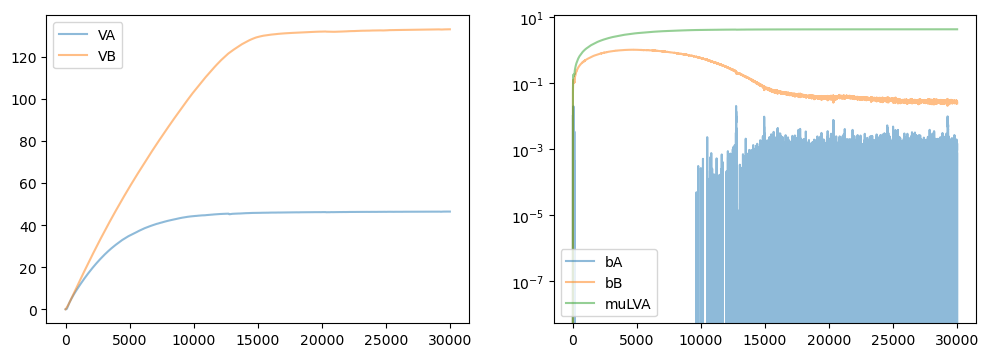

In [52]:
param_name = ["bA", "bB", "bC", "bD", "bE", "bF", "VA", "VB", "VC", "VD", "VE", "VF", "muASV", "muLVA"]
plt.figure(figsize=(12,4));plt.subplot(121)
for i, n in enumerate(param_name):
    if params_est[-1,i] > 20:
        plt.plot(params_est[:,i], label=n, alpha=.5)
        
plt.legend();
plt.subplot(122)
for i, n in enumerate(param_name):
    if params_est[-1,i] <= 20:
        plt.plot(params_est[:,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()

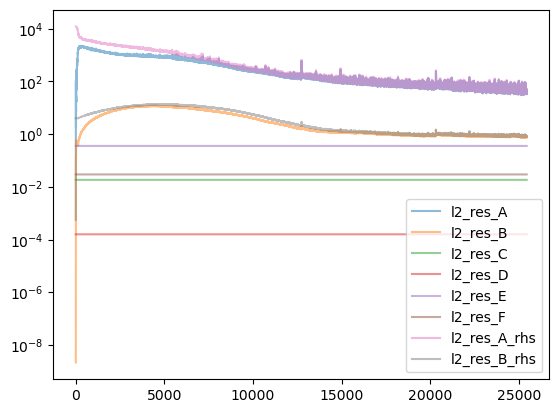

In [53]:
for i, n in enumerate(names):
    plt.plot(losses1[:,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()

In [56]:
@tf.function
def grads(pinn, inputs):    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])
            Cg = tf.squeeze(outputs[:, 2])
            Dg = tf.squeeze(outputs[:, 3])
            Eg = tf.squeeze(outputs[:, 4])
            Fg = tf.squeeze(outputs[:, 5])

            grad_A = tape2.gradient(Ag, inputs)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]
            A_t = grad_A[:, 2]

            grad_B = tape2.gradient(Bg, inputs)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]
            B_t = grad_B[:, 2]
            
#             grad_C = tape2.gradient(Cg, inputs)
#             C_t = grad_C[:, 2]
            
#             grad_D = tape2.gradient(Dg, inputs)
#             D_t = grad_D[:, 2]
            
#             grad_E = tape2.gradient(Eg, inputs)
#             E_t = grad_E[:, 2]
            
#             grad_F = tape2.gradient(Fg, inputs)
#             F_t = grad_F[:, 2]
            

        grad_A_x = tape.gradient(A_x, inputs)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, inputs)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, inputs)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, inputs)
        B_yy = grad_B_y[:, 1]
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            tf.squeeze(Cg), 
            tf.squeeze(Dg), 
            tf.squeeze(Eg), 
            tf.squeeze(Fg))                               
#     return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
#             tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
#             tf.squeeze(Cg), tf.squeeze(C_t),
#             tf.squeeze(Dg), tf.squeeze(D_t),
#             tf.squeeze(Eg), tf.squeeze(E_t),
#             tf.squeeze(Fg), tf.squeeze(F_t))

def to(arr):
    return arr.numpy().reshape(block_x, block_y)

def plot_state(pinn):
        (A, A_xx, A_yy, A_t,
         B, B_xx, B_yy, B_t,
         C,  D,  E,  F, 
        ) = grads(pinn, obs_X)
        
        A_der = DA*( to(A_xx) + to(A_yy))
        B_der = DB*( to(B_xx) + to(B_yy))

        actual_A_der = DA*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
        actual_B_der = DB*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
        # X and Y are misoriented
        A_der = A_der
        B_der = B_der
        
        plot_n_im([to(A), c_restricted[0,:, : , -1], to(B), c_restricted[1,:, :  , -1]], 
          ["A", "Actual A", "B", "Actual B"],          
          figsize=(12, 3)); plt.tight_layout()

        A = c_restricted[0,:, : , -1]
        B = c_restricted[1,:, : , -1]

        
        
        plot_n_im([to(A_xx), c_xx[0,x_slice, y_slice , -1], to(A_yy), c_yy[0,x_slice, y_slice  , -1]], 
          ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
          figsize=(12, 3)); plt.tight_layout()

        plot_n_im([to(B_xx), c_xx[1,x_slice, y_slice  , -1], to(B_yy), c_yy[1,x_slice, y_slice  , -1]],
                  ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
                   ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
                   figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
        plot_n_im([A_der,  actual_A_der],
                  ["RHS A", "Actual RHS A"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([B_der,  actual_B_der],
                  ["RHS B", "Actual RHS B"],          
                  figsize=(12, 3)); plt.tight_layout()
        plt.show()

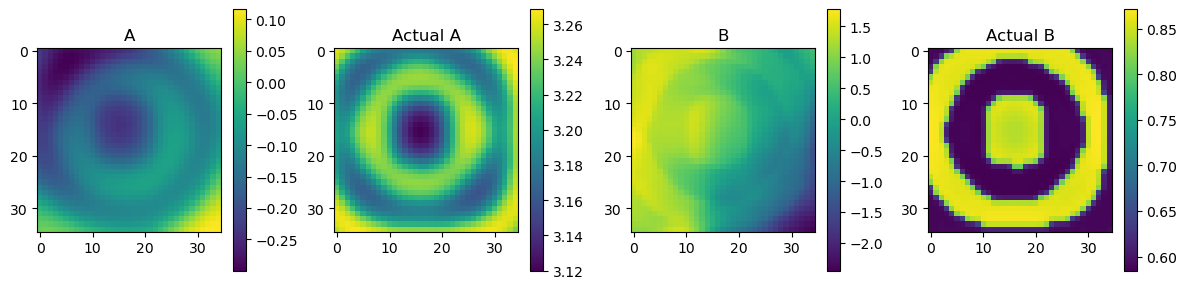

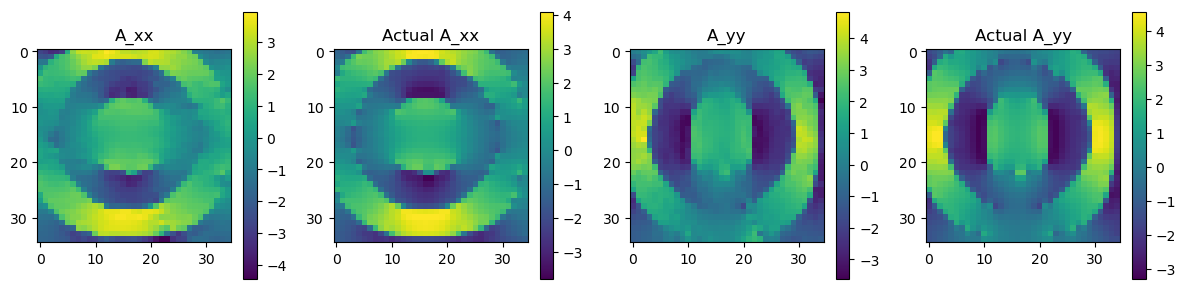

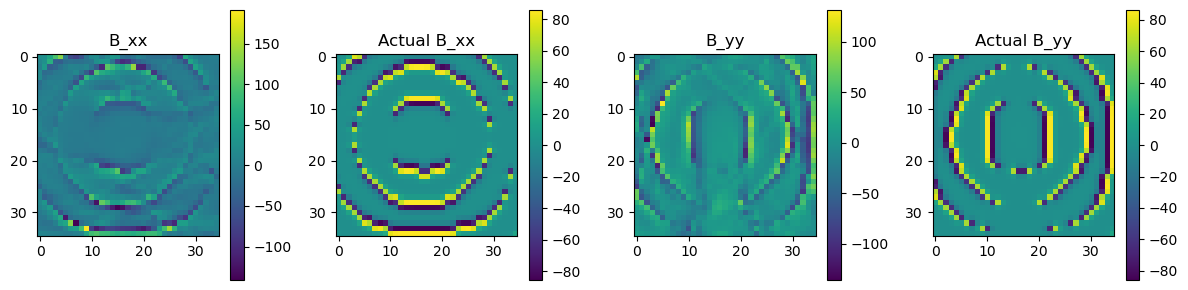

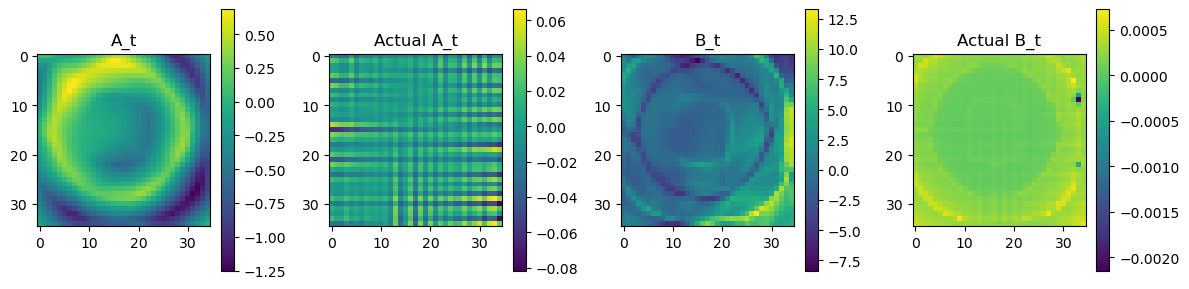

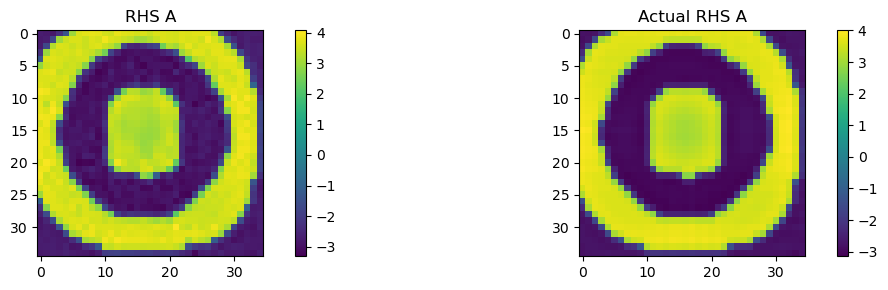

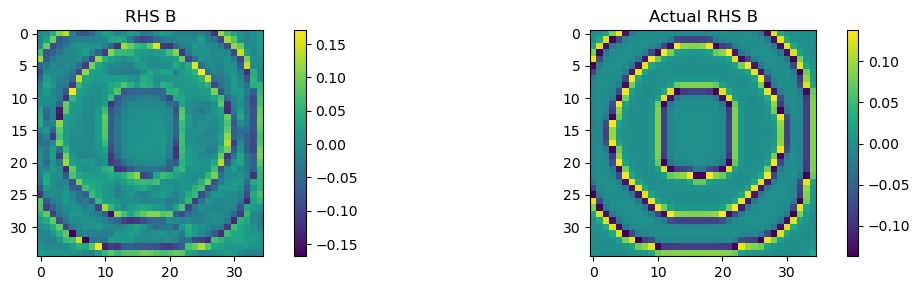

In [57]:
plot_state(pinn1)

In [58]:
(A, A_xx, A_yy, A_t,
         B, B_xx, B_yy, B_t,
         C,  D,  E,  F, 
        ) = grads(pinn1, obs_X)

In [59]:
u_t_act = c_t[0,x_slice, y_slice , -1]
v_t_act = c_t[1,x_slice, y_slice , -1]
print(np.sum(u_t_act**2))
print(np.sum(v_t_act**2))
print(np.sum(ders_t[0, :]**2))
print(np.sum(ders_t[1, :]**2))

0.49224496907994086
6.61899213916773e-05
0.492245
6.6189925e-05


In [60]:
A_der = DA*( to(A_xx) + to(A_yy))
B_der = DB*( to(B_xx) + to(B_yy))

actual_A_der = DA*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
actual_B_der = DB*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]

In [61]:
print(np.sum((A_der-actual_A_der)**2))
print(np.sqrt(np.mean((A_der-actual_A_der)**2)))
print(np.mean(np.abs(A_der-actual_A_der)/np.abs(actual_A_der)))
print(np.sum((B_der-actual_B_der)**2))
print(np.sqrt(np.mean((B_der-actual_B_der)**2)))
print(np.mean(np.abs(B_der-actual_B_der)/np.abs(actual_B_der)))

27.06132579168491
0.14863000436417206
0.03858765524775942
0.7138855807486937
0.024140499982119028
58.72398112501472
